In [1]:
import torch
from torch import nn
from torch.optim import Optimizer
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, ToTensor
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader

from tqdm.auto import tqdm


def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer
    optimizer.step()

@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

#Ideal Dataset and Dataloader organization, don't hesitate to do something else
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

c:\Users\padis\anaconda3\envs\saidl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified


In [3]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc14 = nn.Sequential(
            nn.Linear(512, 4096),
            nn.Dropout(0.5),
            nn.ReLU())
        self.fc15 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc16= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc14(out)
        out = self.fc15(out)
        out = self.fc16(out)
        return out

        

In [13]:
model = VGG16().to(device = 'cuda')
model.load_state_dict(torch.load("modelsaidlFinal.pth", weights_only= True))

<All keys matched successfully>

In [14]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader['test']:
        images = images.to(device = 'cuda')
        labels = labels.to(device = 'cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

Accuracy of the network on the 10000 test images: 82.64 %


In [15]:
mb = get_model_size(model)/MiB
print(f"model size = {mb}MB")

model size = 128.35184478759766MB


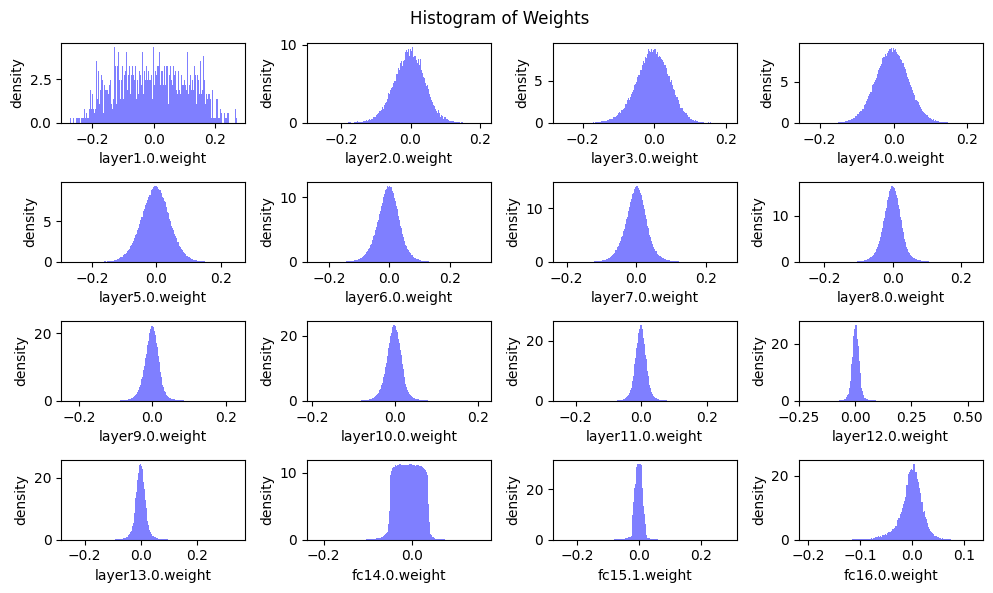

In [16]:
import matplotlib.pyplot as plt
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(4,4, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)
     

In [19]:
import numpy as np
import math
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:

    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()
    num_zeros = round(num_elements * sparsity)
    importance = torch.abs(tensor)
    threshold = torch.kthvalue(importance.flatten(), num_zeros)[0]
    mask = importance > threshold#binary mask 1 for non zereos and 0 for zeros
    tensor.mul_(mask)#multiply with mask to remove values below threshold


    return mask



In [21]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0, scan_end=1.0):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        print(type(param))
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies


sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0, scan_end=1.0)
     

<class 'torch.nn.parameter.Parameter'>


scanning 0/16 weight - layer1.0.weight:  10%|█         | 1/10 [00:07<01:07,  7.48s/it]

    sparsity=0.00: accuracy=82.81%

scanning 0/16 weight - layer1.0.weight:  20%|██        | 2/10 [00:14<00:58,  7.36s/it]

    sparsity=0.10: accuracy=81.99%

scanning 0/16 weight - layer1.0.weight:  30%|███       | 3/10 [00:21<00:51,  7.30s/it]

    sparsity=0.20: accuracy=78.28%

scanning 0/16 weight - layer1.0.weight:  40%|████      | 4/10 [00:29<00:43,  7.29s/it]

    sparsity=0.30: accuracy=64.14%

scanning 0/16 weight - layer1.0.weight:  50%|█████     | 5/10 [00:36<00:36,  7.29s/it]

    sparsity=0.40: accuracy=47.94%

scanning 0/16 weight - layer1.0.weight:  60%|██████    | 6/10 [00:43<00:29,  7.27s/it]

    sparsity=0.50: accuracy=23.13%

scanning 0/16 weight - layer1.0.weight:  70%|███████   | 7/10 [00:51<00:21,  7.27s/it]

    sparsity=0.60: accuracy=10.53%

scanning 0/16 weight - layer1.0.weight:  80%|████████  | 8/10 [00:58<00:14,  7.26s/it]

    sparsity=0.70: accuracy=9.14%

scanning 0/16 weight - layer1.0.weight:  90%|█████████ | 9/10 [01:05<00:07,  7.26s/it]

    sparsity=0.80: accuracy=9.79%

scanning 0/16 weight - layer1.0.weight: 100%|██████████| 10/10 [01:12<00:00,  7.29s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[82.81%, 81.99%, 78.28%, 64.14%, 47.94%, 23.13%, 10.53%, 9.14%, 9.79%, 9.42%]<class 'torch.nn.parameter.Parameter'>


scanning 1/16 weight - layer2.0.weight:  10%|█         | 1/10 [00:07<01:05,  7.27s/it]

    sparsity=0.00: accuracy=82.81%

scanning 1/16 weight - layer2.0.weight:  20%|██        | 2/10 [00:14<00:58,  7.26s/it]

    sparsity=0.10: accuracy=82.82%

scanning 1/16 weight - layer2.0.weight:  30%|███       | 3/10 [00:21<00:50,  7.26s/it]

    sparsity=0.20: accuracy=82.66%

scanning 1/16 weight - layer2.0.weight:  40%|████      | 4/10 [00:29<00:43,  7.27s/it]

    sparsity=0.30: accuracy=82.82%

scanning 1/16 weight - layer2.0.weight:  50%|█████     | 5/10 [00:36<00:36,  7.27s/it]

    sparsity=0.40: accuracy=83.03%

scanning 1/16 weight - layer2.0.weight:  60%|██████    | 6/10 [00:43<00:29,  7.27s/it]

    sparsity=0.50: accuracy=82.51%

scanning 1/16 weight - layer2.0.weight:  70%|███████   | 7/10 [00:50<00:21,  7.27s/it]

    sparsity=0.60: accuracy=80.76%

scanning 1/16 weight - layer2.0.weight:  80%|████████  | 8/10 [00:58<00:14,  7.27s/it]

    sparsity=0.70: accuracy=79.74%

scanning 1/16 weight - layer2.0.weight:  90%|█████████ | 9/10 [01:05<00:07,  7.27s/it]

    sparsity=0.80: accuracy=78.95%

scanning 1/16 weight - layer2.0.weight: 100%|██████████| 10/10 [01:12<00:00,  7.27s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[82.81%, 82.82%, 82.66%, 82.82%, 83.03%, 82.51%, 80.76%, 79.74%, 78.95%, 62.22%]<class 'torch.nn.parameter.Parameter'>


scanning 2/16 weight - layer3.0.weight:  10%|█         | 1/10 [00:07<01:05,  7.27s/it]

    sparsity=0.00: accuracy=82.81%

scanning 2/16 weight - layer3.0.weight:  20%|██        | 2/10 [00:14<00:58,  7.26s/it]

    sparsity=0.10: accuracy=82.77%

scanning 2/16 weight - layer3.0.weight:  30%|███       | 3/10 [00:21<00:50,  7.25s/it]

    sparsity=0.20: accuracy=82.99%

scanning 2/16 weight - layer3.0.weight:  40%|████      | 4/10 [00:29<00:43,  7.27s/it]

    sparsity=0.30: accuracy=82.85%

scanning 2/16 weight - layer3.0.weight:  50%|█████     | 5/10 [00:36<00:36,  7.26s/it]

    sparsity=0.40: accuracy=83.15%

scanning 2/16 weight - layer3.0.weight:  60%|██████    | 6/10 [00:43<00:29,  7.26s/it]

    sparsity=0.50: accuracy=82.59%

scanning 2/16 weight - layer3.0.weight:  70%|███████   | 7/10 [00:50<00:21,  7.27s/it]

    sparsity=0.60: accuracy=81.14%

scanning 2/16 weight - layer3.0.weight:  80%|████████  | 8/10 [00:58<00:14,  7.28s/it]

    sparsity=0.70: accuracy=80.56%

scanning 2/16 weight - layer3.0.weight:  90%|█████████ | 9/10 [01:05<00:07,  7.27s/it]

    sparsity=0.80: accuracy=76.22%

scanning 2/16 weight - layer3.0.weight: 100%|██████████| 10/10 [01:12<00:00,  7.27s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[82.81%, 82.77%, 82.99%, 82.85%, 83.15%, 82.59%, 81.14%, 80.56%, 76.22%, 62.03%]<class 'torch.nn.parameter.Parameter'>


scanning 3/16 weight - layer4.0.weight:  10%|█         | 1/10 [00:07<01:05,  7.27s/it]

    sparsity=0.00: accuracy=82.81%

scanning 3/16 weight - layer4.0.weight:  20%|██        | 2/10 [00:14<00:59,  7.42s/it]

    sparsity=0.10: accuracy=82.87%

scanning 3/16 weight - layer4.0.weight:  30%|███       | 3/10 [00:22<00:51,  7.39s/it]

    sparsity=0.20: accuracy=82.98%

scanning 3/16 weight - layer4.0.weight:  40%|████      | 4/10 [00:29<00:45,  7.55s/it]

    sparsity=0.30: accuracy=83.20%

scanning 3/16 weight - layer4.0.weight:  50%|█████     | 5/10 [00:37<00:38,  7.69s/it]

    sparsity=0.40: accuracy=82.98%

scanning 3/16 weight - layer4.0.weight:  60%|██████    | 6/10 [00:45<00:30,  7.73s/it]

    sparsity=0.50: accuracy=82.76%

scanning 3/16 weight - layer4.0.weight:  70%|███████   | 7/10 [00:53<00:22,  7.61s/it]

    sparsity=0.60: accuracy=81.81%

scanning 3/16 weight - layer4.0.weight:  80%|████████  | 8/10 [01:00<00:15,  7.53s/it]

    sparsity=0.70: accuracy=78.54%

scanning 3/16 weight - layer4.0.weight:  90%|█████████ | 9/10 [01:07<00:07,  7.46s/it]

    sparsity=0.80: accuracy=69.79%

scanning 3/16 weight - layer4.0.weight: 100%|██████████| 10/10 [01:15<00:00,  7.51s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[82.81%, 82.87%, 82.98%, 83.20%, 82.98%, 82.76%, 81.81%, 78.54%, 69.79%, 45.00%]<class 'torch.nn.parameter.Parameter'>


scanning 4/16 weight - layer5.0.weight:  10%|█         | 1/10 [00:07<01:06,  7.36s/it]

    sparsity=0.00: accuracy=82.81%

scanning 4/16 weight - layer5.0.weight:  20%|██        | 2/10 [00:14<00:59,  7.44s/it]

    sparsity=0.10: accuracy=82.88%

scanning 4/16 weight - layer5.0.weight:  30%|███       | 3/10 [00:22<00:52,  7.54s/it]

    sparsity=0.20: accuracy=82.85%

scanning 4/16 weight - layer5.0.weight:  40%|████      | 4/10 [00:30<00:45,  7.52s/it]

    sparsity=0.30: accuracy=82.85%

scanning 4/16 weight - layer5.0.weight:  50%|█████     | 5/10 [00:37<00:37,  7.47s/it]

    sparsity=0.40: accuracy=82.93%

scanning 4/16 weight - layer5.0.weight:  60%|██████    | 6/10 [00:44<00:29,  7.43s/it]

    sparsity=0.50: accuracy=82.38%

scanning 4/16 weight - layer5.0.weight:  70%|███████   | 7/10 [00:52<00:22,  7.41s/it]

    sparsity=0.60: accuracy=81.69%

scanning 4/16 weight - layer5.0.weight:  80%|████████  | 8/10 [00:59<00:14,  7.44s/it]

    sparsity=0.70: accuracy=79.04%

scanning 4/16 weight - layer5.0.weight:  90%|█████████ | 9/10 [01:07<00:07,  7.64s/it]

    sparsity=0.80: accuracy=66.80%

scanning 4/16 weight - layer5.0.weight: 100%|██████████| 10/10 [01:15<00:00,  7.53s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[82.81%, 82.88%, 82.85%, 82.85%, 82.93%, 82.38%, 81.69%, 79.04%, 66.80%, 31.55%]<class 'torch.nn.parameter.Parameter'>


scanning 5/16 weight - layer6.0.weight:  10%|█         | 1/10 [00:07<01:06,  7.43s/it]

    sparsity=0.00: accuracy=82.81%

scanning 5/16 weight - layer6.0.weight:  20%|██        | 2/10 [00:15<01:01,  7.70s/it]

    sparsity=0.10: accuracy=82.82%

scanning 5/16 weight - layer6.0.weight:  30%|███       | 3/10 [00:22<00:53,  7.58s/it]

    sparsity=0.20: accuracy=82.81%

scanning 5/16 weight - layer6.0.weight:  40%|████      | 4/10 [00:30<00:44,  7.50s/it]

    sparsity=0.30: accuracy=82.71%

scanning 5/16 weight - layer6.0.weight:  50%|█████     | 5/10 [00:38<00:38,  7.69s/it]

    sparsity=0.40: accuracy=82.57%

scanning 5/16 weight - layer6.0.weight:  60%|██████    | 6/10 [00:45<00:30,  7.72s/it]

    sparsity=0.50: accuracy=82.46%

scanning 5/16 weight - layer6.0.weight:  70%|███████   | 7/10 [00:53<00:22,  7.61s/it]

    sparsity=0.60: accuracy=81.93%

scanning 5/16 weight - layer6.0.weight:  80%|████████  | 8/10 [01:01<00:15,  7.69s/it]

    sparsity=0.70: accuracy=80.65%

scanning 5/16 weight - layer6.0.weight:  90%|█████████ | 9/10 [01:08<00:07,  7.69s/it]

    sparsity=0.80: accuracy=77.55%

scanning 5/16 weight - layer6.0.weight: 100%|██████████| 10/10 [01:16<00:00,  7.63s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[82.81%, 82.82%, 82.81%, 82.71%, 82.57%, 82.46%, 81.93%, 80.65%, 77.55%, 61.91%]<class 'torch.nn.parameter.Parameter'>


scanning 6/16 weight - layer7.0.weight:  10%|█         | 1/10 [00:08<01:13,  8.14s/it]

    sparsity=0.00: accuracy=82.81%

scanning 6/16 weight - layer7.0.weight:  20%|██        | 2/10 [00:15<01:02,  7.84s/it]

    sparsity=0.10: accuracy=82.79%

scanning 6/16 weight - layer7.0.weight:  30%|███       | 3/10 [00:23<00:53,  7.66s/it]

    sparsity=0.20: accuracy=82.81%

scanning 6/16 weight - layer7.0.weight:  40%|████      | 4/10 [00:30<00:45,  7.57s/it]

    sparsity=0.30: accuracy=82.69%

scanning 6/16 weight - layer7.0.weight:  50%|█████     | 5/10 [00:38<00:38,  7.61s/it]

    sparsity=0.40: accuracy=82.50%

scanning 6/16 weight - layer7.0.weight:  60%|██████    | 6/10 [00:45<00:30,  7.53s/it]

    sparsity=0.50: accuracy=82.06%

scanning 6/16 weight - layer7.0.weight:  70%|███████   | 7/10 [00:53<00:22,  7.46s/it]

    sparsity=0.60: accuracy=81.11%

scanning 6/16 weight - layer7.0.weight:  80%|████████  | 8/10 [01:00<00:14,  7.43s/it]

    sparsity=0.70: accuracy=79.20%

scanning 6/16 weight - layer7.0.weight:  90%|█████████ | 9/10 [01:07<00:07,  7.40s/it]

    sparsity=0.80: accuracy=73.79%

scanning 6/16 weight - layer7.0.weight: 100%|██████████| 10/10 [01:15<00:00,  7.51s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[82.81%, 82.79%, 82.81%, 82.69%, 82.50%, 82.06%, 81.11%, 79.20%, 73.79%, 60.23%]<class 'torch.nn.parameter.Parameter'>


scanning 7/16 weight - layer8.0.weight:  10%|█         | 1/10 [00:07<01:06,  7.34s/it]

    sparsity=0.00: accuracy=82.81%

scanning 7/16 weight - layer8.0.weight:  20%|██        | 2/10 [00:14<00:58,  7.32s/it]

    sparsity=0.10: accuracy=82.80%

scanning 7/16 weight - layer8.0.weight:  30%|███       | 3/10 [00:22<00:51,  7.41s/it]

    sparsity=0.20: accuracy=82.81%

scanning 7/16 weight - layer8.0.weight:  40%|████      | 4/10 [00:30<00:45,  7.65s/it]

    sparsity=0.30: accuracy=82.73%

scanning 7/16 weight - layer8.0.weight:  50%|█████     | 5/10 [00:37<00:38,  7.69s/it]

    sparsity=0.40: accuracy=82.74%

scanning 7/16 weight - layer8.0.weight:  60%|██████    | 6/10 [00:45<00:31,  7.77s/it]

    sparsity=0.50: accuracy=82.50%

scanning 7/16 weight - layer8.0.weight:  70%|███████   | 7/10 [00:53<00:23,  7.83s/it]

    sparsity=0.60: accuracy=81.87%

scanning 7/16 weight - layer8.0.weight:  80%|████████  | 8/10 [01:01<00:15,  7.72s/it]

    sparsity=0.70: accuracy=80.29%

scanning 7/16 weight - layer8.0.weight:  90%|█████████ | 9/10 [01:09<00:07,  7.81s/it]

    sparsity=0.80: accuracy=75.06%

scanning 7/16 weight - layer8.0.weight: 100%|██████████| 10/10 [01:17<00:00,  7.72s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[82.81%, 82.80%, 82.81%, 82.73%, 82.74%, 82.50%, 81.87%, 80.29%, 75.06%, 56.08%]<class 'torch.nn.parameter.Parameter'>


scanning 8/16 weight - layer9.0.weight:  10%|█         | 1/10 [00:08<01:13,  8.11s/it]

    sparsity=0.00: accuracy=82.81%

scanning 8/16 weight - layer9.0.weight:  20%|██        | 2/10 [00:15<01:02,  7.82s/it]

    sparsity=0.10: accuracy=82.81%

scanning 8/16 weight - layer9.0.weight:  30%|███       | 3/10 [00:23<00:53,  7.60s/it]

    sparsity=0.20: accuracy=82.79%

scanning 8/16 weight - layer9.0.weight:  40%|████      | 4/10 [00:30<00:44,  7.48s/it]

    sparsity=0.30: accuracy=82.80%

scanning 8/16 weight - layer9.0.weight:  50%|█████     | 5/10 [00:37<00:37,  7.44s/it]

    sparsity=0.40: accuracy=82.74%

scanning 8/16 weight - layer9.0.weight:  60%|██████    | 6/10 [00:45<00:29,  7.40s/it]

    sparsity=0.50: accuracy=82.67%

scanning 8/16 weight - layer9.0.weight:  70%|███████   | 7/10 [00:52<00:22,  7.41s/it]

    sparsity=0.60: accuracy=82.29%

scanning 8/16 weight - layer9.0.weight:  80%|████████  | 8/10 [00:59<00:14,  7.39s/it]

    sparsity=0.70: accuracy=81.03%

scanning 8/16 weight - layer9.0.weight:  90%|█████████ | 9/10 [01:07<00:07,  7.39s/it]

    sparsity=0.80: accuracy=77.77%

scanning 8/16 weight - layer9.0.weight: 100%|██████████| 10/10 [01:14<00:00,  7.46s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[82.81%, 82.81%, 82.79%, 82.80%, 82.74%, 82.67%, 82.29%, 81.03%, 77.77%, 66.82%]<class 'torch.nn.parameter.Parameter'>


scanning 9/16 weight - layer10.0.weight:  10%|█         | 1/10 [00:07<01:06,  7.36s/it]

    sparsity=0.00: accuracy=82.81%

scanning 9/16 weight - layer10.0.weight:  20%|██        | 2/10 [00:14<00:58,  7.33s/it]

    sparsity=0.10: accuracy=82.80%

scanning 9/16 weight - layer10.0.weight:  30%|███       | 3/10 [00:22<00:51,  7.33s/it]

    sparsity=0.20: accuracy=82.79%

scanning 9/16 weight - layer10.0.weight:  40%|████      | 4/10 [00:29<00:43,  7.33s/it]

    sparsity=0.30: accuracy=82.80%

scanning 9/16 weight - layer10.0.weight:  50%|█████     | 5/10 [00:36<00:36,  7.35s/it]

    sparsity=0.40: accuracy=82.73%

scanning 9/16 weight - layer10.0.weight:  60%|██████    | 6/10 [00:44<00:29,  7.33s/it]

    sparsity=0.50: accuracy=82.68%

scanning 9/16 weight - layer10.0.weight:  70%|███████   | 7/10 [00:51<00:21,  7.33s/it]

    sparsity=0.60: accuracy=82.39%

scanning 9/16 weight - layer10.0.weight:  80%|████████  | 8/10 [00:58<00:14,  7.32s/it]

    sparsity=0.70: accuracy=81.73%

scanning 9/16 weight - layer10.0.weight:  90%|█████████ | 9/10 [01:05<00:07,  7.32s/it]

    sparsity=0.80: accuracy=78.84%

scanning 9/16 weight - layer10.0.weight: 100%|██████████| 10/10 [01:13<00:00,  7.34s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[82.81%, 82.80%, 82.79%, 82.80%, 82.73%, 82.68%, 82.39%, 81.73%, 78.84%, 65.73%]<class 'torch.nn.parameter.Parameter'>


scanning 10/16 weight - layer11.0.weight:  10%|█         | 1/10 [00:07<01:06,  7.44s/it]

    sparsity=0.00: accuracy=82.81%

scanning 10/16 weight - layer11.0.weight:  20%|██        | 2/10 [00:14<00:59,  7.40s/it]

    sparsity=0.10: accuracy=82.81%

scanning 10/16 weight - layer11.0.weight:  30%|███       | 3/10 [00:22<00:51,  7.41s/it]

    sparsity=0.20: accuracy=82.80%

scanning 10/16 weight - layer11.0.weight:  40%|████      | 4/10 [00:29<00:44,  7.39s/it]

    sparsity=0.30: accuracy=82.79%

scanning 10/16 weight - layer11.0.weight:  50%|█████     | 5/10 [00:36<00:36,  7.38s/it]

    sparsity=0.40: accuracy=82.73%

scanning 10/16 weight - layer11.0.weight:  60%|██████    | 6/10 [00:44<00:29,  7.39s/it]

    sparsity=0.50: accuracy=82.69%

scanning 10/16 weight - layer11.0.weight:  70%|███████   | 7/10 [00:51<00:22,  7.38s/it]

    sparsity=0.60: accuracy=82.41%

scanning 10/16 weight - layer11.0.weight:  80%|████████  | 8/10 [00:59<00:14,  7.36s/it]

    sparsity=0.70: accuracy=81.46%

scanning 10/16 weight - layer11.0.weight:  90%|█████████ | 9/10 [01:06<00:07,  7.36s/it]

    sparsity=0.80: accuracy=77.65%

scanning 10/16 weight - layer11.0.weight: 100%|██████████| 10/10 [01:13<00:00,  7.38s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[82.81%, 82.81%, 82.80%, 82.79%, 82.73%, 82.69%, 82.41%, 81.46%, 77.65%, 59.90%]<class 'torch.nn.parameter.Parameter'>


scanning 11/16 weight - layer12.0.weight:  10%|█         | 1/10 [00:07<01:06,  7.36s/it]

    sparsity=0.00: accuracy=82.81%

scanning 11/16 weight - layer12.0.weight:  20%|██        | 2/10 [00:14<00:58,  7.37s/it]

    sparsity=0.10: accuracy=82.81%

scanning 11/16 weight - layer12.0.weight:  30%|███       | 3/10 [00:24<00:59,  8.45s/it]

    sparsity=0.20: accuracy=82.81%

scanning 11/16 weight - layer12.0.weight:  40%|████      | 4/10 [00:33<00:50,  8.48s/it]

    sparsity=0.30: accuracy=82.80%

scanning 11/16 weight - layer12.0.weight:  50%|█████     | 5/10 [00:40<00:40,  8.08s/it]

    sparsity=0.40: accuracy=82.76%

scanning 11/16 weight - layer12.0.weight:  60%|██████    | 6/10 [00:47<00:31,  7.85s/it]

    sparsity=0.50: accuracy=82.79%

scanning 11/16 weight - layer12.0.weight:  70%|███████   | 7/10 [00:55<00:23,  7.72s/it]

    sparsity=0.60: accuracy=82.55%

scanning 11/16 weight - layer12.0.weight:  80%|████████  | 8/10 [01:02<00:15,  7.62s/it]

    sparsity=0.70: accuracy=81.93%

scanning 11/16 weight - layer12.0.weight:  90%|█████████ | 9/10 [01:10<00:07,  7.60s/it]

    sparsity=0.80: accuracy=78.95%

scanning 11/16 weight - layer12.0.weight: 100%|██████████| 10/10 [01:17<00:00,  7.78s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[82.81%, 82.81%, 82.81%, 82.80%, 82.76%, 82.79%, 82.55%, 81.93%, 78.95%, 59.15%]<class 'torch.nn.parameter.Parameter'>


scanning 12/16 weight - layer13.0.weight:  10%|█         | 1/10 [00:07<01:07,  7.45s/it]

    sparsity=0.00: accuracy=82.81%

scanning 12/16 weight - layer13.0.weight:  20%|██        | 2/10 [00:14<00:59,  7.46s/it]

    sparsity=0.10: accuracy=82.81%

scanning 12/16 weight - layer13.0.weight:  30%|███       | 3/10 [00:22<00:52,  7.48s/it]

    sparsity=0.20: accuracy=82.80%

scanning 12/16 weight - layer13.0.weight:  40%|████      | 4/10 [00:29<00:44,  7.50s/it]

    sparsity=0.30: accuracy=82.81%

scanning 12/16 weight - layer13.0.weight:  50%|█████     | 5/10 [00:37<00:37,  7.47s/it]

    sparsity=0.40: accuracy=82.77%

scanning 12/16 weight - layer13.0.weight:  60%|██████    | 6/10 [00:44<00:29,  7.43s/it]

    sparsity=0.50: accuracy=82.74%

scanning 12/16 weight - layer13.0.weight:  70%|███████   | 7/10 [00:52<00:22,  7.41s/it]

    sparsity=0.60: accuracy=82.76%

scanning 12/16 weight - layer13.0.weight:  80%|████████  | 8/10 [00:59<00:14,  7.39s/it]

    sparsity=0.70: accuracy=82.60%

scanning 12/16 weight - layer13.0.weight:  90%|█████████ | 9/10 [01:06<00:07,  7.38s/it]

    sparsity=0.80: accuracy=81.91%

scanning 12/16 weight - layer13.0.weight: 100%|██████████| 10/10 [01:14<00:00,  7.41s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[82.81%, 82.81%, 82.80%, 82.81%, 82.77%, 82.74%, 82.76%, 82.60%, 81.91%, 75.13%]<class 'torch.nn.parameter.Parameter'>


scanning 13/16 weight - fc14.0.weight:  10%|█         | 1/10 [00:07<01:06,  7.36s/it]

    sparsity=0.00: accuracy=82.81%

scanning 13/16 weight - fc14.0.weight:  20%|██        | 2/10 [00:14<00:58,  7.32s/it]

    sparsity=0.10: accuracy=82.80%

scanning 13/16 weight - fc14.0.weight:  30%|███       | 3/10 [00:22<00:53,  7.60s/it]

    sparsity=0.20: accuracy=82.82%

scanning 13/16 weight - fc14.0.weight:  40%|████      | 4/10 [00:29<00:44,  7.50s/it]

    sparsity=0.30: accuracy=82.83%

scanning 13/16 weight - fc14.0.weight:  50%|█████     | 5/10 [00:37<00:37,  7.44s/it]

    sparsity=0.40: accuracy=82.80%

scanning 13/16 weight - fc14.0.weight:  60%|██████    | 6/10 [00:44<00:29,  7.40s/it]

    sparsity=0.50: accuracy=82.80%

scanning 13/16 weight - fc14.0.weight:  70%|███████   | 7/10 [00:51<00:22,  7.37s/it]

    sparsity=0.60: accuracy=82.76%

scanning 13/16 weight - fc14.0.weight:  80%|████████  | 8/10 [00:59<00:14,  7.37s/it]

    sparsity=0.70: accuracy=82.63%

scanning 13/16 weight - fc14.0.weight:  90%|█████████ | 9/10 [01:06<00:07,  7.36s/it]

    sparsity=0.80: accuracy=82.64%

scanning 13/16 weight - fc14.0.weight: 100%|██████████| 10/10 [01:13<00:00,  7.39s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[82.81%, 82.80%, 82.82%, 82.83%, 82.80%, 82.80%, 82.76%, 82.63%, 82.64%, 82.39%]<class 'torch.nn.parameter.Parameter'>


scanning 14/16 weight - fc15.1.weight:  10%|█         | 1/10 [00:07<01:05,  7.33s/it]

    sparsity=0.00: accuracy=82.81%

scanning 14/16 weight - fc15.1.weight:  20%|██        | 2/10 [00:14<00:59,  7.40s/it]

    sparsity=0.10: accuracy=82.81%

scanning 14/16 weight - fc15.1.weight:  30%|███       | 3/10 [00:22<00:52,  7.45s/it]

    sparsity=0.20: accuracy=82.80%

scanning 14/16 weight - fc15.1.weight:  40%|████      | 4/10 [00:29<00:44,  7.45s/it]

    sparsity=0.30: accuracy=82.81%

scanning 14/16 weight - fc15.1.weight:  50%|█████     | 5/10 [00:37<00:37,  7.45s/it]

    sparsity=0.40: accuracy=82.81%

scanning 14/16 weight - fc15.1.weight:  60%|██████    | 6/10 [00:44<00:29,  7.44s/it]

    sparsity=0.50: accuracy=82.80%

scanning 14/16 weight - fc15.1.weight:  70%|███████   | 7/10 [00:52<00:22,  7.43s/it]

    sparsity=0.60: accuracy=82.78%

scanning 14/16 weight - fc15.1.weight:  80%|████████  | 8/10 [00:59<00:14,  7.45s/it]

    sparsity=0.70: accuracy=82.74%

scanning 14/16 weight - fc15.1.weight:  90%|█████████ | 9/10 [01:06<00:07,  7.45s/it]

    sparsity=0.80: accuracy=82.71%

scanning 14/16 weight - fc15.1.weight: 100%|██████████| 10/10 [01:14<00:00,  7.44s/it]


    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[82.81%, 82.81%, 82.80%, 82.81%, 82.81%, 82.80%, 82.78%, 82.74%, 82.71%, 82.60%]<class 'torch.nn.parameter.Parameter'>


scanning 15/16 weight - fc16.0.weight:  10%|█         | 1/10 [00:07<01:05,  7.33s/it]

    sparsity=0.00: accuracy=82.81%

scanning 15/16 weight - fc16.0.weight:  20%|██        | 2/10 [00:14<00:58,  7.33s/it]

    sparsity=0.10: accuracy=82.79%

scanning 15/16 weight - fc16.0.weight:  30%|███       | 3/10 [00:21<00:51,  7.33s/it]

    sparsity=0.20: accuracy=82.78%

scanning 15/16 weight - fc16.0.weight:  40%|████      | 4/10 [00:29<00:43,  7.33s/it]

    sparsity=0.30: accuracy=82.78%

scanning 15/16 weight - fc16.0.weight:  50%|█████     | 5/10 [00:36<00:36,  7.34s/it]

    sparsity=0.40: accuracy=82.76%

scanning 15/16 weight - fc16.0.weight:  60%|██████    | 6/10 [00:43<00:29,  7.33s/it]

    sparsity=0.50: accuracy=82.76%

scanning 15/16 weight - fc16.0.weight:  70%|███████   | 7/10 [00:51<00:21,  7.33s/it]

    sparsity=0.60: accuracy=82.76%

scanning 15/16 weight - fc16.0.weight:  80%|████████  | 8/10 [00:58<00:14,  7.34s/it]

    sparsity=0.70: accuracy=82.34%

scanning 15/16 weight - fc16.0.weight:  90%|█████████ | 9/10 [01:05<00:07,  7.34s/it]

    sparsity=0.80: accuracy=81.70%

scanning 15/16 weight - fc16.0.weight: 100%|██████████| 10/10 [01:13<00:00,  7.33s/it]

    sparsity=[0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[82.81%, 82.79%, 82.78%, 82.78%, 82.76%, 82.76%, 82.76%, 82.34%, 81.70%, 71.37%]

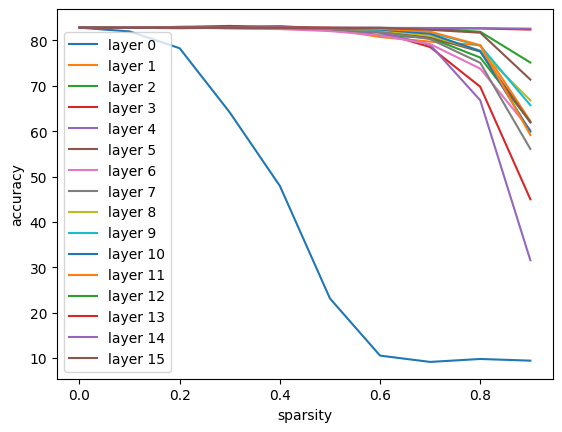

In [23]:

for i in range(len(accuracies)):
    plt.plot(sparsities, accuracies[i], label=f'layer {i}')

plt.xlabel('sparsity')
plt.ylabel('accuracy')
plt.legend()

plt.show()

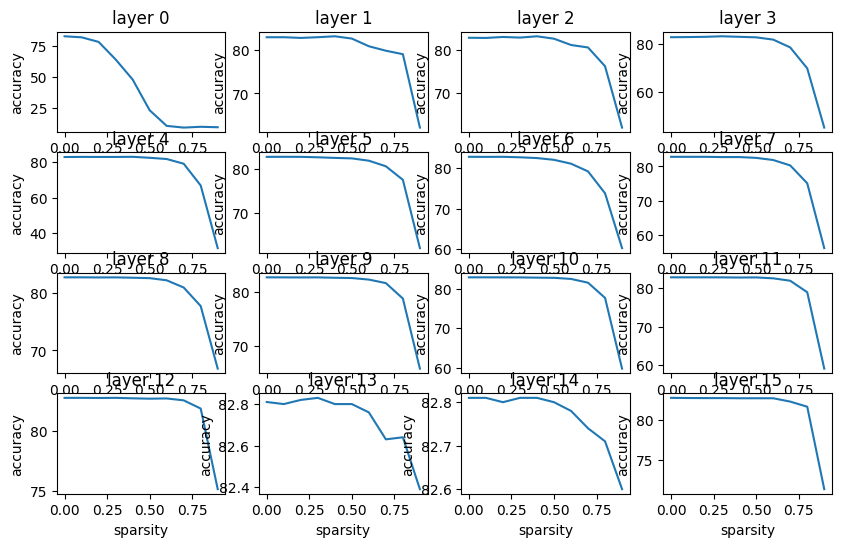

In [24]:
# plt.plot(sparsities, accuracies[2])

# plt.xlabel('sparsity')
# plt.ylabel('accuracy')
# plt.legend()

# plt.show()
fig, ax = plt.subplots(4, 4, figsize=(10,6))
ax = ax.ravel()
for i in range(len(accuracies)):
    ax[i].plot(sparsities, accuracies[i])
    ax[i].set_title(f'layer {i}')
    ax[i].set_xlabel('sparsity')
    ax[i].set_ylabel('accuracy')

plt.show()

In [35]:
#from the sensitivity scan we can see that the best sparsity for each layer is as follows
sparsities = [0,0.4,0.4,0.5, 0.5, 0.5, 0.5,0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.2, 0.4, 0.5]


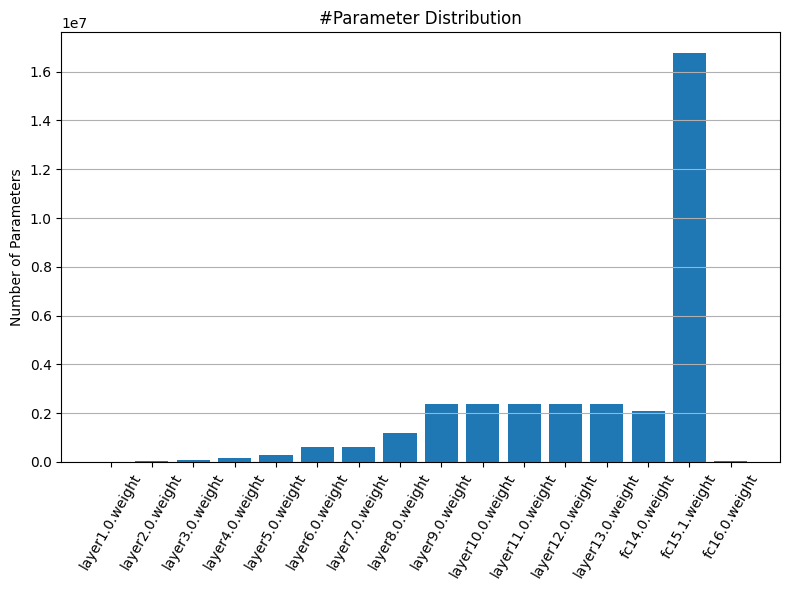

In [30]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

In [32]:
dense_model_size = get_model_size(model)
dense_model_size/MiB

128.35184478759766

After pruning with sparsity dictionary
The sparsity of each layer becomes
  layer1.0.weight: 0.00
  layer2.0.weight: 0.40
  layer3.0.weight: 0.40
  layer4.0.weight: 0.50
  layer5.0.weight: 0.50
  layer6.0.weight: 0.50
  layer7.0.weight: 0.60
  layer8.0.weight: 0.70
  layer9.0.weight: 0.80
  layer10.0.weight: 0.90
  layer11.0.weight: 0.50
  layer12.0.weight: 0.50
  layer13.0.weight: 0.60
  fc14.0.weight: 0.20
  fc15.1.weight: 0.40
  fc16.0.weight: 0.50
Sparse model has size=64.74 MiB = 50.44% of dense model size


Sparse model has accuracy=42.03% before fintuning


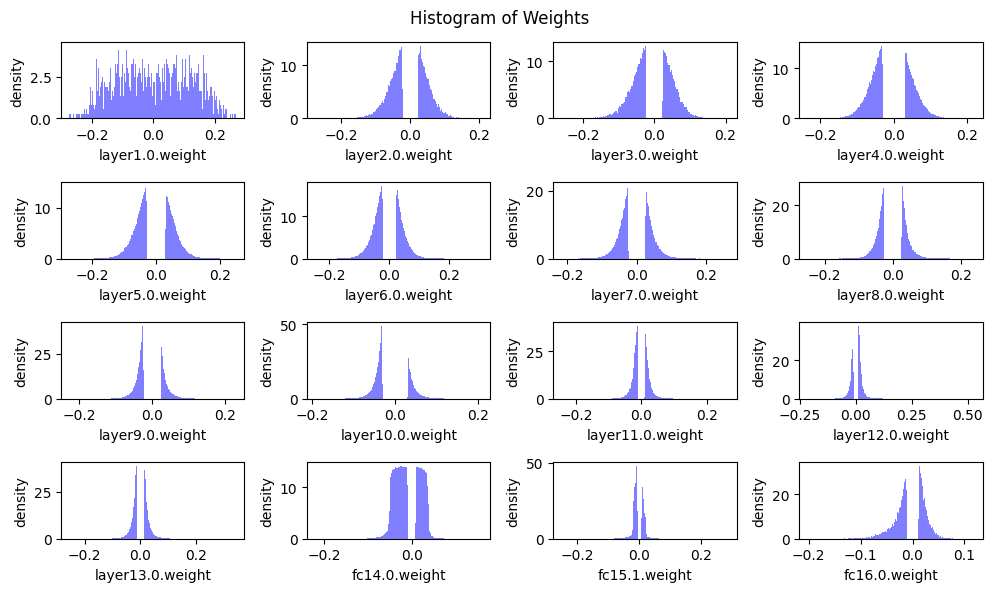

In [37]:
class FineGrainedPruner:
    def __init__(self, model, sparsities):
        self.masks = FineGrainedPruner.prune(model, sparsities)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsities):
        masks = dict()
        i = 0
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsities[i])
                i +=1
            
        return masks
    
pruner = FineGrainedPruner(model, sparsities)
print(f'After pruning with sparsity dictionary')
# for name, sparsity in sparsities.items():
#     print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if param.dim() > 1:
        print(f'  {name}: {get_sparsity(param):.2f}')
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)
     

In [38]:
import copy
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer)
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


    Epoch 1 Accuracy 83.77% / Best Accuracy: 83.77%


    Epoch 2 Accuracy 81.94% / Best Accuracy: 83.77%


    Epoch 3 Accuracy 84.24% / Best Accuracy: 84.24%


    Epoch 4 Accuracy 81.55% / Best Accuracy: 84.24%


    Epoch 5 Accuracy 83.82% / Best Accuracy: 84.24%


In [39]:
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")
     

Sparse model has size=101.67 MiB = 79.22% of dense model size


Sparse model has accuracy=84.24% after fintuning
